# HW1 - CS391L Machine Learning WB (Spring 23)
*Submission by - Sidharth Nair (sn25377)*

## Problem Statement

**Million Dollar Question**

For this problem, you will work on the Netflix dataset, where one needs to predict missing (movie, user) ratings. The problem of predicting missing values for a recommender system is formally known as Collaborative Filtering. Read more about the Netflix challenge and the dataset [here](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data).

The complete Netflix dataset has 480,189 users, 17,770 movies, and 100,480,507 ratings. So, the scale of the problem is huge. For this assignment we will work on a much smaller subset of 2000 users, 1821 movies and 220,845 ratings. You can download this subset dataset from Canvas > Files > HW1 > dataset.zip

We will take an approach based on Matrix Factorization which was also used by a leading team for Netflix challenge. Let us first introduce some notation. Let there be $u$ users and $m$ movies and let $R\in \mathbb{R}^{u\times m}$ be the ratings matrix where element $R_{ij}$ is the rating given by user $i$ for movie $j$. Note that the matrix $R$ has many missing values - in the entire Netflix dataset, $\sim 94\%$ of the entries are missing. Think of factoring the matrix $R\approx U^T M$, where $U\in \mathbb{R}^{k\times u}$ and $M \in \mathbb{R}^{k\times m}$ and $k\ll \min(u, m)$. Intuitively, you can think of column $\bm{u}_i$ of $U$ as a low-dimensional feature vector for the $i$-th user, and the column $\bm{m}_j$ of $M$ as a low-dimensional feature vector for the $j$-th movie.

Using the above notation,  the rating $R_{ij}$ for a movie $j$ by user $i$ is approximated as $R_{ij}\approx \bm{u}_i^T\bm{m}_j$. Thus, the Matrix Factorization approach involves finding $U$ and $M$ such that $U^TM$ is as close to $R$ as possible. Formally the problem can be stated as:
\begin{equation}
  %\label{eq:prob1}
  \min_{U, M}\ \|R-U^TM\|_F^2+\lamda(\|U\|_F^2+\|M\|_F^2),
\end{equation}
where $\|\cdot\|_F$ denotes the Frobenius norm, and where we have added regularization terms (as in ridge regression) and the regularization parameter $\lambda\in [0, 1]$.

This problem is in general hard to solve as both $U$ and $M$ need to be inferred and no known method guarantees the optimal solution. Instead, we use  a heuristic which works well in practice. We use the method of Alternating Minimization, where in each iteration we fix $U$ to compute $M$, and  subsequently fix $M$ to compute $U$, and so on. Now we describe the method to compute $M$ assuming $U$ to be fixed. 

Let $U$  be fixed, then equation 1 reduces to:
\begin{equation*}
  %\label{eq:prob2}
  \min_{M}\ \|R-U^TM\|_F^2+\lambda\|M\|_F^2,
\end{equation*}
This problem can be decoupled in terms of columns of $M$, $\bm{m}_j$, i.e., 
\begin{equation*}
  %\label{eq:prob2}
  \min_{\{\bm{m}_1, \bm{m}_2, \dots, \bm{m}_m\}}\ \sum_j\|\bm{r}_j-U^T\bm{m}_j\|_2^2+\lambda\sum_j\|\bm{m}_j\|_2^2,
\end{equation*}
where $\bm{r}_j$ denote the $j$-th column of $R$. Thus, we can solve a separate ridge regression problem for each $j$, i.e.,
\begin{equation*}
  %\label{eq:prob2}
  \min_{\bm{m}_j}\ \|\bm{r}_j-U^T\bm{m}_j\|_2^2+\lambda\|\bm{m}_j\|_2^2,
\end{equation*}
However, the vector $\bm{r}_j$, which represents ratings for  movie $j$, may have many missing values. Let there be $n_j$ known ratings for the movie $j$. Then, the ridge regression should be solved using only $n_j$ ratings, i.e. let $\bm{r}_j^{({\cal K_j})}\in \mathbb{R}^{n_j}$ denote the known ratings for movie $j$, and $U^{({\cal K}_j)}\in\mathbb{R}^{k\times n_j}$ denote the submatrix of $U$ for the corresponding users who rated movie $j$. Thus the problem can be written as:
\begin{equation*}
  %\label{eq:prob2}
  \min_{\bm{m}_j}\ \|\bm{r}_j^{({\cal K_j})}-\left(U^{({\cal K}_j)}\right)^T\bm{m}_j\|_2^2+\lambda\|\bm{m}_j\|_2^2,
\end{equation*}

An analogous procedure can be used for computing $U$. 

So, for each iteration compute $U$ and $M$ using the procedure given above. Repeat this procedure for a fixed number of iterations. Initialize $U$ and $M$ randomly, fix the number of iterations $\tau$ as $30$ and fix $k=10$. 

## Implementation

### Imports

In [121]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Data Loading

In [136]:
trn_R = np.load('dataset/trn_R.npy')
val_R = np.load('dataset/val_R.npy')

### Your Code to solve ridge regression

In [133]:
def solve_ridge(X, y, lamda):
    """Solve the ridge regression problem.
    
    Args:
        X: A numpy array of shape (N, D) containing a minibatch of N
            data points; each point has dimension D.
        y: A numpy array of shape (N,) containing labels for the minibatch.
        lamda: The regularization strength.
    
    Returns:
        w: A numpy array of shape (D,) containing the learned weight.
    """
    X_t = X.transpose()
    w = np.matmul(np.linalg.inv(np.matmul(X_t, X) + lamda * np.identity(X.shape[1])), np.matmul(X_t, y))
    return w

### Your Code to solve matrix completion using alternating minimization

In [132]:
def update_U(U, M, R, lamda):
    """Update the user matrix U assuming M is fixed
    
    Args:
        U: A numpy array of shape (k, N) containing the current user matrix.
        M: A numpy array of shape (k, M) containing the current movie matrix.
        R: A numpy array of shape (N, M) containing the ratings matrix (NOTE: R has many missing values, indicated by 0, which should be ignored during training)
        lamda: The regularization strength.
    
    Returns:
        U: A numpy array of shape (k, N) containing the updated user matrix.
    """
    k = U.shape[0]
    num_users = R.shape[0]
    for user in range(num_users):
        # get nonzero ratings for user
        indices = np.nonzero(R[user])
        n_i = len(indices[0])
        r_i = np.take(R[user], indices).reshape((n_i,))
        # get corresponding movie columns
        M_i = np.take(M, indices, axis=1).squeeze(axis=1).transpose()
        # call ridge regression
        u_i = solve_ridge(M_i, r_i, lamda)
        # replace column of U
        U[:, user] = u_i[:]
    return U

def update_M(U, M, R, lamda):
    """Update the movie matrix M assuming U is fixed
    
    Args:
        U: A numpy array of shape (k, N) containing the current user matrix.
        M: A numpy array of shape (k, M) containing the current movie matrix.
        R: A numpy array of shape (N, M) containing the ratings matrix (NOTE: R has many missing values, indicated by 0, which should be ignored during training)
        lamda: The regularization strength.
    
    Returns:
        M: A numpy array of shape (k, M) containing the updated movie matrix.
    """
    k = M.shape[0]
    num_movies = R.shape[1]
    for movie in range(num_movies):
        # get nonzero ratings for movie
        indices = np.nonzero(R[:, movie])
        n_i = len(indices[0])
        r_i = np.take(R[:, movie], indices).reshape((n_i,))
        # get corresponding user columns
        U_i = np.take(U, indices, axis=1).squeeze(axis=1).transpose()
        # call ridge regression
        m_i = solve_ridge(U_i, r_i, lamda)
        # replace column of M
        M[:, movie] = m_i[:]
    return M

In [107]:
def train(U, M, R, lamda, tau):
    """Train U, M using alternating minimization
    
    Args:
        U: A numpy array of shape (k, N) containing the user matrix.
        M: A numpy array of shape (k, M) containing the movie matrix.
        R: A numpy array of shape (N, M) containing the ratings matrix (NOTE: R has many missing values, indicated by 0, which should be ignored during training)
        lamda: The regularization strength.
        tau: The number of iterations to train for.
    
    Returns:
        U: A numpy array of shape (k, N) containing the trained user matrix.
        M: A numpy array of shape (k, M) containing the trained movie matrix.
    """
    for i in range(tau):
        update_U(U, M, R, lamda)
        update_M(U, M, R, lamda)
    
    return U, M

### Your code for evaluation

In [108]:
def evaluate(pred_R, true_R):
    """Evaluate the model on the given rating matrix R and return the RMSE

    Args:
        pred_R: A numpy array of shape (N, M) containing the predicted ratings matrix.
        true_R: A numpy array of shape (N, M) containing the true ratings matrix (NOTE: R has many missing values, indicated by 0, which should be ignored during evaluation)
    
    Returns:
        rmse: The RMSE of the predicted ratings matrix.
    """
    return np.sqrt(np.mean((pred_R-true_R)**2))

## Execute your code and answer HW questions

### Define hyperparameters ($\lambda$, $\tau$, $k$) and initialize learnable parameters $U$, $M$

In [109]:
# Your code here
lamda = 0
tau = 30
k = 10

U = np.random.rand(k, trn_R.shape[0])
M = np.random.rand(k, trn_R.shape[1])

### **Question 1**
Select $λ = 0$ and compute $U$ and $M$. What are the problems you face?
### **Your answer**
TODO: 

In [110]:
# Your code here
lamda = 0
train(U, M, trn_R, lamda, tau)

LinAlgError: Singular matrix

### **Question 2**
train your model on multiple values for $\lambda$ and record the Root Mean Squared Error (RMSE) on both validation and train set for each run. Report the following:
- Plot of $\lambda$ vs RMSE on validation set and training set
- Optimal RMSE on validation set along with the optimal $\lambda$

### **Your answer**
TODO: 


Optimal RMSE: 0.15686382724050935 Optimal lamda 485165195.40978974


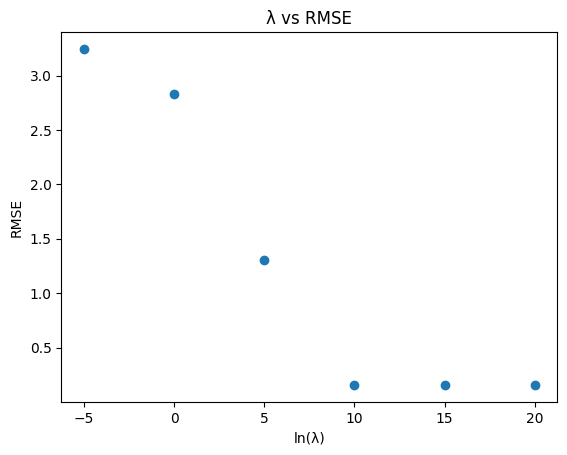

In [119]:
# Your code here
lamda_exps = [x for x in range(-5, 25, 5)]
errors = []
optimal_lamda = None
optimal_rmse = None
for lamda_exp in lamda_exps:
    lamda = np.e ** lamda_exp
    trained_U, trained_M = train(U, M, trn_R, lamda, tau)
    pred_R = np.matmul(trained_U.transpose(), trained_M)
    rmse = evaluate(pred_R, val_R)
    errors.append(rmse)
    if optimal_rmse is None or rmse < optimal_rmse:
        optimal_rmse = rmse
        optimal_lamda = lamda
print("Optimal RMSE:", optimal_rmse, "Optimal lamda", lamda)

plt.scatter(lamda_exps, errors)
plt.title("λ vs RMSE")
plt.xlabel("ln(λ)")
plt.ylabel("RMSE")
plt.xticks(lamda_exps)
plt.show()

### **Question 3** 
Now let us consider preprocessing the data in order to remove some inherent bias in the data. First center the complete data using global mean. Now, center each row of the ratings matrix $R$ to mean 0, i.e. remove user mean for each row. Similarly center each coumn of the resulting matrix. Perform the above operations on known ratings only. After this preprocessing, repeat question 2 above and report the optimal RMSE on validation set. NOTE that after factorization, you need to add the global mean and the user/movie bias for prediction. Report RMSE obtained. How does RMSE change? Explain.
### **Your Answer**
TODO: 

In [142]:
print(np.count_nonzero(trn_R), np.count_nonzero(val_R))

220845 6770


Optimal RMSE: 0.25767606869381476 Optimal lamda 20.085536923187664


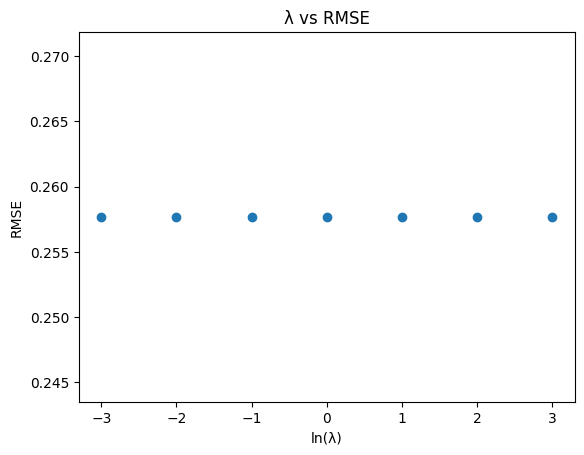

In [140]:
# Your code here
global_mean = np.mean(trn_R)
centered_trn_R = trn_R - global_mean

row_means = np.mean(centered_trn_R, axis=1)
for i in range(len(row_means)):
    centered_trn_R[i] = centered_trn_R[i] - row_means[i]

col_means = np.mean(centered_trn_R, axis=0)
for i in range(len(col_means)):
    centered_trn_R[:, i] = centered_trn_R[:, i] - col_means[i]

lamda_exps = [x for x in range(-3, 4, 1)]
errors = []
optimal_lamda = None
optimal_rmse = None
for lamda_exp in lamda_exps:
    lamda = np.e ** lamda_exp
    trained_U, trained_M = train(U, M, centered_trn_R, lamda, tau)
    pred_R = np.matmul(trained_U.transpose(), trained_M)
    pred_R += global_mean
    for i in range(len(row_means)):
        centered_trn_R[i] = centered_trn_R[i] + row_means[i]
    for i in range(len(col_means)):
        centered_trn_R[:, i] = centered_trn_R[:, i] + col_means[i]
    rmse = evaluate(pred_R, val_R)
    errors.append(rmse)
    if optimal_rmse is None or rmse < optimal_rmse:
        optimal_rmse = rmse
        optimal_lamda = lamda
print("Optimal RMSE:", optimal_rmse, "Optimal lamda", lamda)

plt.scatter(lamda_exps, errors)
plt.title("λ vs RMSE")
plt.xlabel("ln(λ)")
plt.ylabel("RMSE")
plt.xticks(lamda_exps)
plt.show()

In [146]:
print(pred_R)
print(global_mean, row_means[0], col_means[0])

[[0.21097694 0.21097694 0.21097694 ... 0.21097694 0.21097694 0.21097694]
 [0.21097694 0.21097694 0.21097694 ... 0.21097694 0.21097694 0.21097694]
 [0.21097694 0.21097694 0.21097694 ... 0.21097694 0.21097694 0.21097694]
 ...
 [0.21097694 0.21097694 0.21097694 ... 0.21097694 0.21097694 0.21097694]
 [0.21097694 0.21097694 0.21097694 ... 0.21097694 0.21097694 0.21097694]
 [0.21097694 0.21097694 0.21097694 ... 0.21097694 0.21097694 0.21097694]]
0.21097693574958815 0.03559088412959984 0.08202306425041093


### **Question 4**
What other initialization for $U$ and $M$ can be used? What is the problem with using the zero matrix as the initialization for $U$ and $M$.
### **Your answer**
TODO: 

In [ ]:
# Your code here